# **Лабораторна робота №4**
## з дисципліни **"Аналіз часових рядів"**

##### *За темою:* **"Побудова математичних моделей з трендом та їх прогнозів"**

<div style="display: flex;">

<div style="flex: 1;">
    <i>Виконавці роботи:</i><br>
    бригада №21
    <br><br>
    <i><b>
    Баштовий Іван<br>
    Гармаш Іван<br>
    Гавлицький Іван<br>
    Харитонов Олександр<br>
    Ходаковський Артур
    </i></b>
</div>

<div style="flex: 1;">
<i>Прийняла:</i>
<br><br><br><br>
<i><b>Левенчук<br> Людмила Борисівна</i></b>
</div>

</div>

##### *Мета роботи:*  Навчитись враховувати тренд і сезонність при побудові математичних моделей часових рядів та будувати їх прогнози

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 8]

### **Реалізація оптимізатора:**

In [3]:
class Optimizer:

    @staticmethod
    def directional_derivative(function, point: tuple, direction: tuple) -> float:
        h = 10**(-6)
        arg1 = np.array(point) + h*np.array(direction)
        arg2 = np.array(point) - h*np.array(direction)
        return (function(arg1) - function(arg2))/(2*h)
    
    @staticmethod
    def gradient(function, point: tuple) -> tuple:
        dim = len(point)
        g = []
        for i in np.arange(dim):
            g.append(Optimizer.directional_derivative(function, point, direction=((0,)*i + (1,)*1 + (0,)*(dim - i - 1))))
        return tuple(g)
    
    def gradient_descent(self, function, initial_point: tuple, epsilon: float):
        def step_splitting(function, point: tuple) -> float:
            alpha = 1
            h = np.array(Optimizer.gradient(function, point))
            while function(point - alpha*h) >= function(point):
                alpha = alpha/2
            return alpha
        
        x_k_old = np.array(initial_point)
        alpha = step_splitting(function, x_k_old)
        x_k = x_k_old - alpha*np.array(Optimizer.gradient(function, x_k_old))

        while abs(function(x_k) - function(x_k_old)) >= epsilon:
            x_k_old = np.copy(x_k)
            alpha = step_splitting(function, x_k_old)
            x_k = x_k_old - alpha*np.array(Optimizer.gradient(function, x_k_old))

        return x_k

Реалізація поліноміальної регресії, авторегресії та авторегресії з ковзним середнім:

In [4]:
class Polynomial_regression:
    def __init__(self, degree=1):
        self.degree = degree
        self.w = np.random.normal(0, 2/(self.degree + 1 + 1), size=(self.degree + 1))

    def __call__(self, data):
        data = np.stack([np.power(data, i) for i in range(self.degree + 1)], axis=-1)
        return np.dot(data, self.w)

    def fit(self, train_data, train_labels):
        train_data = np.stack([np.power(train_data, i) for i in range(self.degree + 1)], axis=-1)
        
        w = self.w
        mse = lambda w: np.sum(np.square(train_labels - np.dot(train_data, w)))
        opt = Optimizer()
        w_fitted = opt.gradient_descent(mse, w, 1e-9)
        self.w = w_fitted

In [5]:
class AR:
    def __init__(self, order=1):
        self.order = order
        self.w = np.random.normal(0, 2/(self.order + 1 + 1), size=(self.order + 1))

    def __call__(self, data):
        X = np.stack([data[i:(len(data) - self.order + i)] for i in range(self.order)], axis=-1)
        X = np.c_[np.ones(len(data) - self.order), X]
        return np.dot(X, self.w)
    
    def fit(self, train_data):
        X = np.stack([train_data[i:(len(train_data) - self.order + i)] for i in range(self.order)], axis=-1)
        X = np.c_[np.ones(len(train_data) - self.order), X]
        y = train_data[self.order:]

        w = self.w
        mse = lambda w: np.sum(np.square(y - np.dot(X, w)))
        opt = Optimizer()
        w_fitted = opt.gradient_descent(mse, w, 1e-9)
        self.w = w_fitted
    
    def plot(self, data):
        y = data[self.order:]
        out = self(data)
        plt.plot(y, label="data", marker=".")
        plt.plot(out, color='blue', label="predicted values", marker=".", alpha=0.5)
        plt.legend()
        plt.suptitle(f"Model performance: (MSE: {metrics.mean_squared_error(y, self(data)).round(2)}, MAE: {metrics.mean_absolute_error(y, self(data)).round(2)}, R^2: {metrics.r2_score(y, self(data)).round(2)})")
        plt.show()

In [6]:
class ARMA:
    def __init__(self, p=1, q=1):
        self.p = p
        self.q = q
        self.w1 = np.random.normal(0, 2/(self.p + 1 + 1), size=(self.p + 1))
        self.w2 = np.random.normal(0, 2/(self.q + 1 + 1), size=(self.q + 1))

    def __call__(self, data):
        X_ar = np.stack([data[i:(len(data) - self.p + i)] for i in range(self.p)], axis=-1)
        X_ar = np.c_[np.ones(len(data) - self.p), X_ar]
        y = data[self.p:]

        out = np.dot(X_ar, self.w1)
        residuals = y - out

        X_ma = np.stack([residuals[i:(len(residuals) - self.q + i)] for i in range(self.q)], axis=-1)
        X_ma = np.c_[np.ones(len(residuals) - self.q), X_ma]

        return out[self.q:] + np.dot(X_ma, self.w2)
    
    def fit(self, train_data):
        X_ar = np.stack([train_data[i:(len(train_data) - self.p + i)] for i in range(self.p)], axis=-1)
        X_ar = np.c_[np.ones(len(train_data) - self.p), X_ar]
        y = train_data[self.p:]

        w1 = self.w1
        mse = lambda w: np.sum(np.square(y - np.dot(X_ar, w)))
        opt = Optimizer()
        w1_fitted = opt.gradient_descent(mse, w1, 1e-9)
        self.w1 = w1_fitted

        out = np.dot(X_ar, self.w1)
        residuals = y - out

        X_ma = np.stack([residuals[i:(len(residuals) - self.q + i)] for i in range(self.q)], axis=-1)
        X_ma = np.c_[np.ones(len(residuals) - self.q), X_ma]
        res = residuals[self.q:]

        w2 = self.w2
        mse = lambda w: np.sum(np.square(res - np.dot(X_ma, w)))
        opt = Optimizer()
        w2_fitted = opt.gradient_descent(mse, w2, 1e-9)
        self.w2 = w2_fitted
    
    def plot(self, data):
        y = data[self.p + self.q:]
        out = self(data)
        plt.plot(y, label="data", marker=".")
        plt.plot(out, color='blue', label="predicted values", marker=".", alpha=0.5)
        plt.legend()
        plt.suptitle(f"Model performance: (MSE: {metrics.mean_squared_error(y, self(data)).round(2)}, MAE: {metrics.mean_absolute_error(y, self(data)).round(2)}, R^2: {metrics.r2_score(y, self(data)).round(2)})")
        plt.show()

### **Dataset A:**

In [7]:
data = np.log(np.loadtxt("./data/EXPCA.txt"))

In [8]:
data.shape

(415,)

Розіб'ємо вибірку на навчальну та валідаційну

In [9]:
train_ratio = 0.9

In [10]:
train_size = int(train_ratio * data.shape[0])
indexes = np.arange(data.shape[0])

data_train = data[:train_size]
data_test = data[train_size:]

In [11]:
print(f"Train shape: {data_train.shape}")
print(f"Test shape: {data_test.shape}")

Train shape: (373,)
Test shape: (42,)


Представимо дані графічно

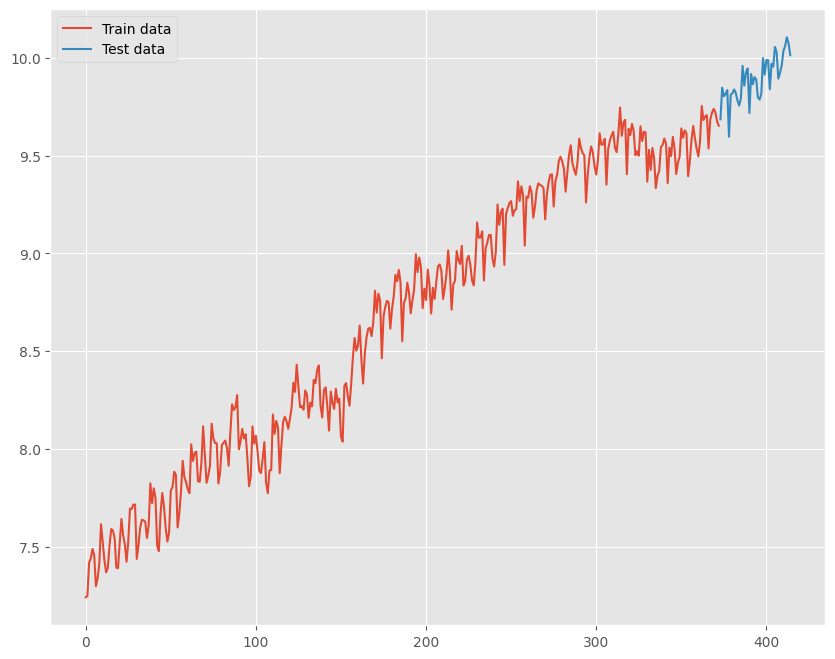

In [12]:
plt.plot(indexes[:train_size], data_train, label="Train data")
plt.plot(indexes[train_size:], data_test, label="Test data")
plt.legend()
plt.show()

Лінія тренду

In [13]:
trend_1 = Polynomial_regression(degree=1)
trend_1.fit(indexes[:train_size], data_train)

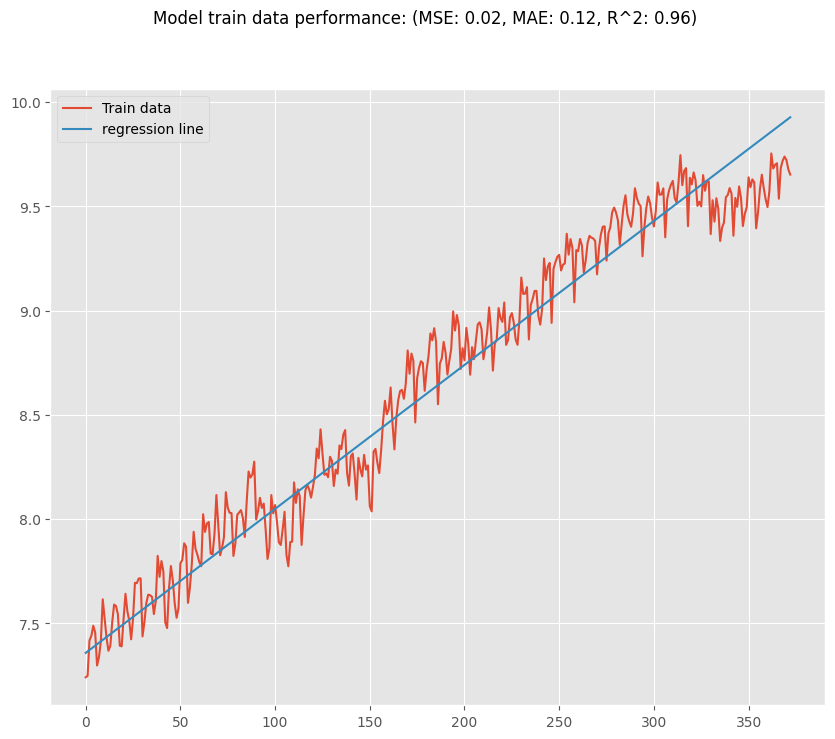

In [14]:
trend_1_preds = trend_1(indexes[:train_size])

plt.plot(indexes[:train_size], data_train, label="Train data")
# plt.plot(indexes[train_size:], data_test, label="Test data")

plt.plot(indexes[:train_size], trend_1_preds, label="regression line")
plt.suptitle(f"Model train data performance: \
(MSE: {metrics.mean_squared_error(data_train, trend_1_preds).round(2)}, \
MAE: {metrics.mean_absolute_error(data_train, trend_1_preds).round(2)}, \
R^2: {metrics.r2_score(data_train, trend_1_preds).round(2)})")

plt.legend()
plt.show()

AR

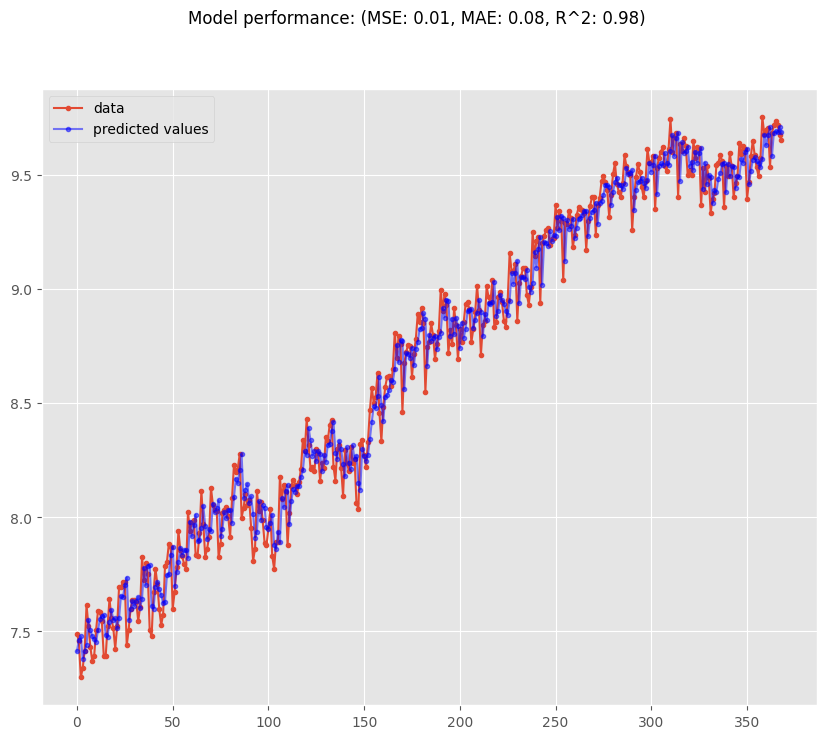

In [15]:
ar = AR(order=4)
ar.fit(data_train)

ar.plot(data_train)

ARMA

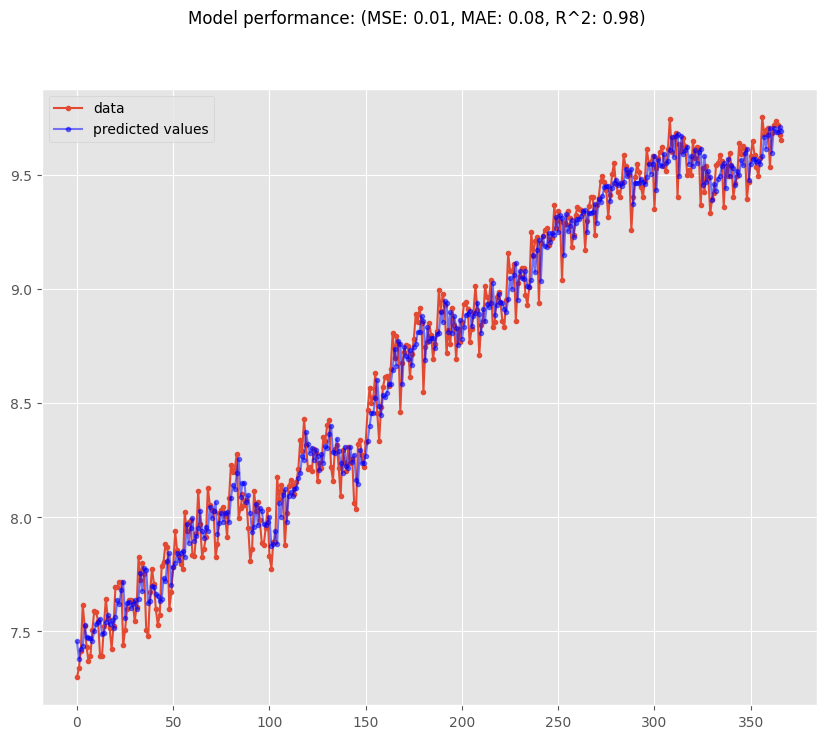

In [16]:
arma = ARMA(4, 2)
arma.fit(data_train)
arma.plot(data_train)

ARIMA

Підберемо порядок інтегрування для ARIMA:

In [17]:
adfuller(data_train)[1]

0.8135068651138766

In [18]:
adfuller(data_train[1:] - data_train[:-1])[1]

8.049045776271331e-05

Використаємо перший порядок інтегрування

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


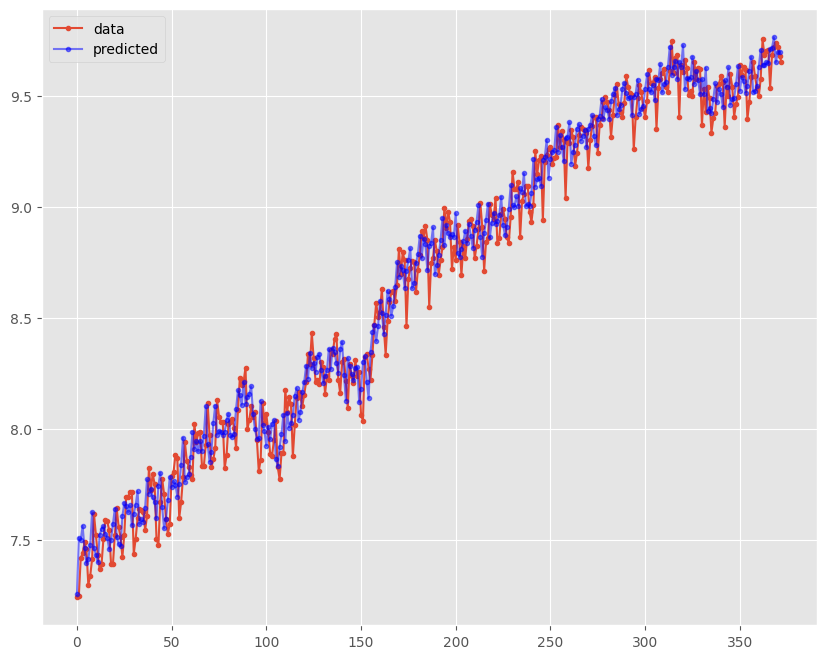

In [19]:
arima = ARIMA(data_train, order=(4, 2, 1))
arima_fitted = arima.fit()

plt.plot(data_train, label="data", marker=".")
plt.plot(arima_fitted.predict(2, train_size), color="blue", label="predicted", marker=".", alpha=0.5)
plt.legend()
plt.show()

Порівняння статичного прогнозу:

In [20]:
def generate_dfs(dynamic=False):
    models_data = pd.DataFrame(columns=['order', 'trained_model', 'preds'], index=['TREND', 'AR', 'MA', 'ARIMA'])

    # order
    models_data['order'] = [(1,), (4, 0, 0), (4, 2, 0), (4, 2, 1)]

    # trained_model
    models_data.loc['TREND', 'trained_model'] = trend_1
    models_data.loc['AR':, 'trained_model'] = models_data.loc['AR':, 'order'].apply(lambda args: ARIMA(data_train, order=args).fit())

    # preds
    models_data.loc['TREND', 'preds'] = str(list(trend_1(indexes[train_size:])))
    models_data.loc['AR':, 'preds'] = models_data.loc['AR':, 'trained_model'].apply(lambda model: str(list(model.predict(start=train_size, end=indexes[-1], dynamic=dynamic))))
    models_data['preds'] = models_data['preds'].apply(lambda x: np.array(eval(x)))



    # preds
    preds_dict = {}

    preds_dict['DATA'] = data_test
    for model, row in models_data.iterrows():
        preds_dict[f"{model}{row['order']}"] = row['preds']


    preds_df = pd.DataFrame(
        data=preds_dict,
        index=indexes[train_size:]
    )


    # metrics
    metrics_dict = {
        'mse': metrics.mean_squared_error,
        'mae': metrics.mean_absolute_error,
        'mape': metrics.mean_absolute_percentage_error,
        'theil': lambda data, pred: np.sqrt(np.mean(np.square(data - pred)))/(np.std(data) + np.std(pred))
    }

    metrics_df = pd.DataFrame(columns=models_data.index, index=metrics_dict.keys()) 

    for metric in metrics_dict.keys():
        for model in models_data.index:
            metrics_df.loc[metric, model] = metrics_dict[metric](data_test, models_data.loc[model, 'preds'])

    return preds_df, metrics_df

In [21]:
preds_df, metrics_df = generate_dfs(dynamic=False)

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
preds_df

,DATA,"TREND(1,)","AR(4, 0, 0)","MA(4, 2, 0)","ARIMA(4, 2, 1)"
373,9.686096,9.934445,9.672833,9.660898,9.696300
374,9.847964,9.941350,9.681378,9.662905,9.732966
375,9.803954,9.948255,9.675644,9.649150,9.747706
376,9.816136,9.955161,9.666912,9.624015,9.738820
377,9.835450,9.962066,9.665646,9.605576,9.717491
378,9.596935,9.968971,9.666513,9.602058,9.723225
379,9.811926,9.975877,9.665343,9.596259,9.743805
380,9.818382,9.982782,9.662413,9.583672,9.762880
381,9.838762,9.989687,9.660057,9.566406,9.771975
382,9.821046,9.996593,9.658524,9.551193,9.766520


In [23]:
metrics_df

,TREND,AR,MA,ARIMA
mse,0.039432,0.080147,0.2814,0.007386
mae,0.185385,0.255777,0.472873,0.074973
mape,0.018799,0.02573,0.047566,0.007561
theil,1.022082,2.133892,2.07071,0.458956


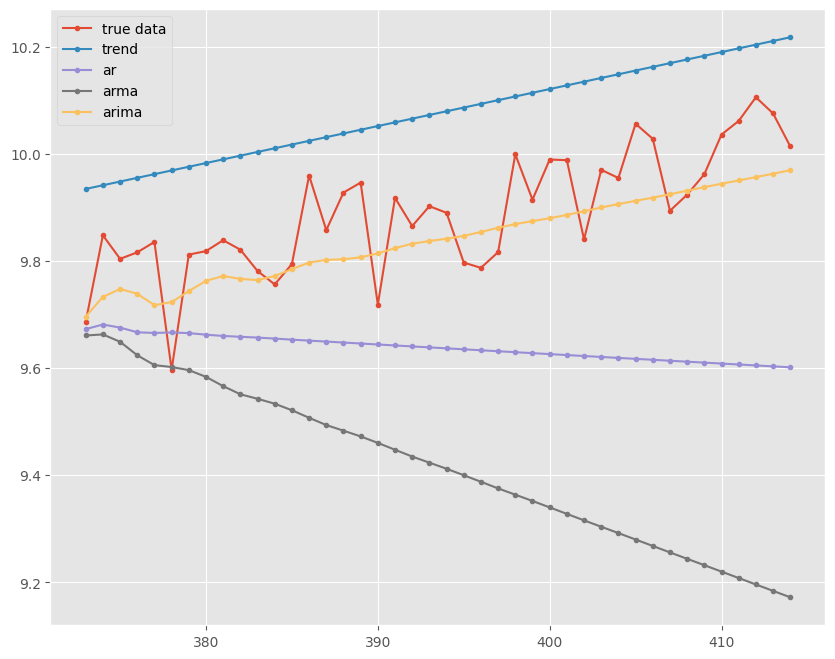

In [24]:
plt.plot(indexes[train_size:], data_test, label="true data", marker=".")

plt.plot(preds_df['TREND(1,)'], label="trend", marker=".")
plt.plot(preds_df['AR(4, 0, 0)'], label="ar", marker=".")
plt.plot(preds_df['MA(4, 2, 0)'], label="arma", marker=".")
plt.plot(preds_df['ARIMA(4, 2, 1)'], label="arima", marker=".")
plt.legend()
# plt.xticks(ticks=range(0, 37, 2), labels=range(750, 787, 2))
plt.show()

Порівняння динамічного прогнозу:

In [25]:
preds_df, metrics_df = generate_dfs(dynamic=True)

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
preds_df

,DATA,"TREND(1,)","AR(4, 0, 0)","MA(4, 2, 0)","ARIMA(4, 2, 1)"
373,9.686096,9.934445,9.672833,9.660898,9.696300
374,9.847964,9.941350,9.681378,9.662905,9.732966
375,9.803954,9.948255,9.675644,9.649150,9.747706
376,9.816136,9.955161,9.666912,9.624015,9.738820
377,9.835450,9.962066,9.665646,9.605576,9.717491
378,9.596935,9.968971,9.666513,9.602058,9.723225
379,9.811926,9.975877,9.665343,9.596259,9.743805
380,9.818382,9.982782,9.662413,9.583672,9.762880
381,9.838762,9.989687,9.660057,9.566406,9.771975
382,9.821046,9.996593,9.658524,9.551193,9.766520


In [27]:
metrics_df

,TREND,AR,MA,ARIMA
mse,0.039432,0.080147,0.2814,0.007386
mae,0.185385,0.255777,0.472873,0.074973
mape,0.018799,0.02573,0.047566,0.007561
theil,1.022082,2.133892,2.07071,0.458956


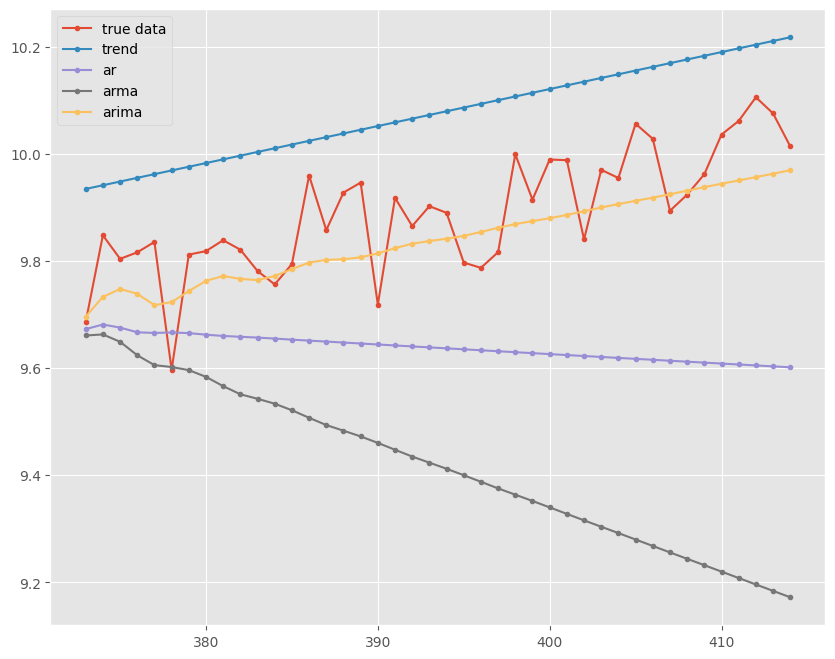

In [28]:
plt.plot(indexes[train_size:], data_test, label="true data", marker=".")

plt.plot(preds_df['TREND(1,)'], label="trend", marker=".")
plt.plot(preds_df['AR(4, 0, 0)'], label="ar", marker=".")
plt.plot(preds_df['MA(4, 2, 0)'], label="arma", marker=".")
plt.plot(preds_df['ARIMA(4, 2, 1)'], label="arima", marker=".")
plt.legend()
# plt.xticks(ticks=range(0, 37, 2), labels=range(750, 787, 2))
plt.show()

Dataset B:

In [29]:
data = np.log(np.loadtxt("./data/RSAFSNA.txt"))

In [30]:
data.shape

(200,)

Розіб'ємо вибірку на навчальну та валідаційну

In [31]:
train_ratio = 0.9

In [32]:
train_size = int(train_ratio * data.shape[0])
indexes = np.arange(data.shape[0])

data_train = data[:train_size]
data_test = data[train_size:]

In [33]:
print(f"Train shape: {data_train.shape}")
print(f"Test shape: {data_test.shape}")

Train shape: (180,)
Test shape: (20,)


Представимо дані графічно

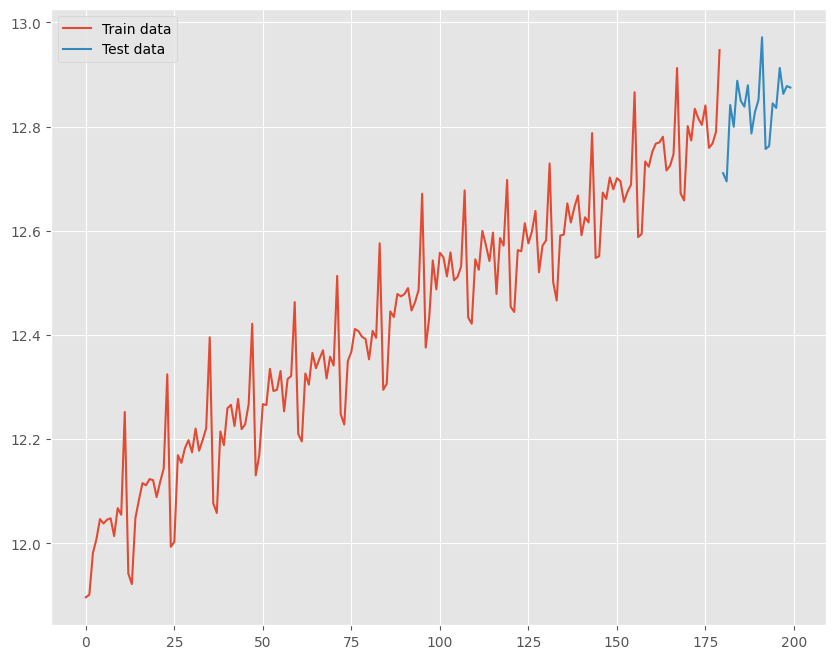

In [34]:
plt.plot(indexes[:train_size], data_train, label="Train data")
plt.plot(indexes[train_size:], data_test, label="Test data")
plt.legend()
plt.show()

Лінія тренду

In [35]:
trend_1 = Polynomial_regression(degree=1)
trend_1.fit(indexes[:train_size], data_train)

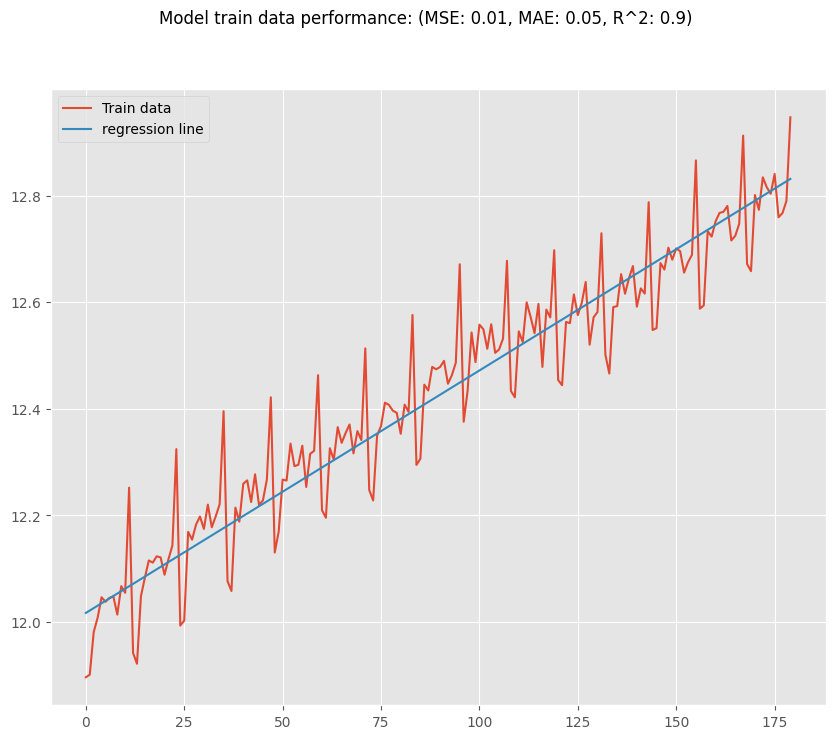

In [36]:
trend_1_preds = trend_1(indexes[:train_size])

plt.plot(indexes[:train_size], data_train, label="Train data")
# plt.plot(indexes[train_size:], data_test, label="Test data")

plt.plot(indexes[:train_size], trend_1_preds, label="regression line")
plt.suptitle(f"Model train data performance: \
(MSE: {metrics.mean_squared_error(data_train, trend_1_preds).round(2)}, \
MAE: {metrics.mean_absolute_error(data_train, trend_1_preds).round(2)}, \
R^2: {metrics.r2_score(data_train, trend_1_preds).round(2)})")

plt.legend()
plt.show()

AR

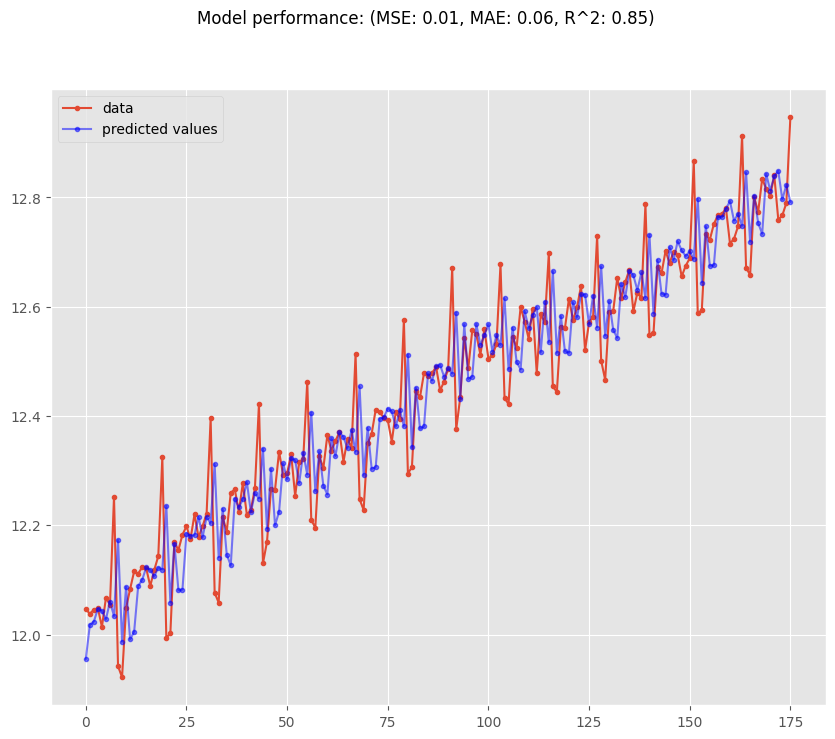

In [37]:
ar = AR(order=4)
ar.fit(data_train)

ar.plot(data_train)

ARMA

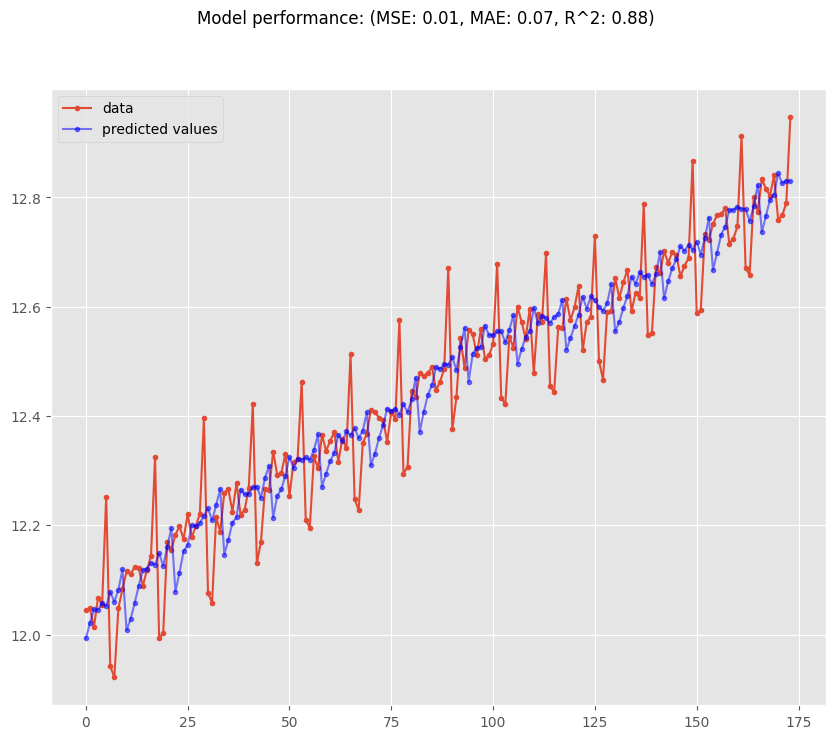

In [38]:
arma = ARMA(4, 2)
arma.fit(data_train)
arma.plot(data_train)

ARIMA

Підберемо порядок інтегрування для ARIMA:

In [39]:
adfuller(data_train)[1]

0.560302693020356

In [40]:
adfuller(data_train[1:] - data_train[:-1])[1]

0.02381887561709301

Використаємо перший порядок інтегрування

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


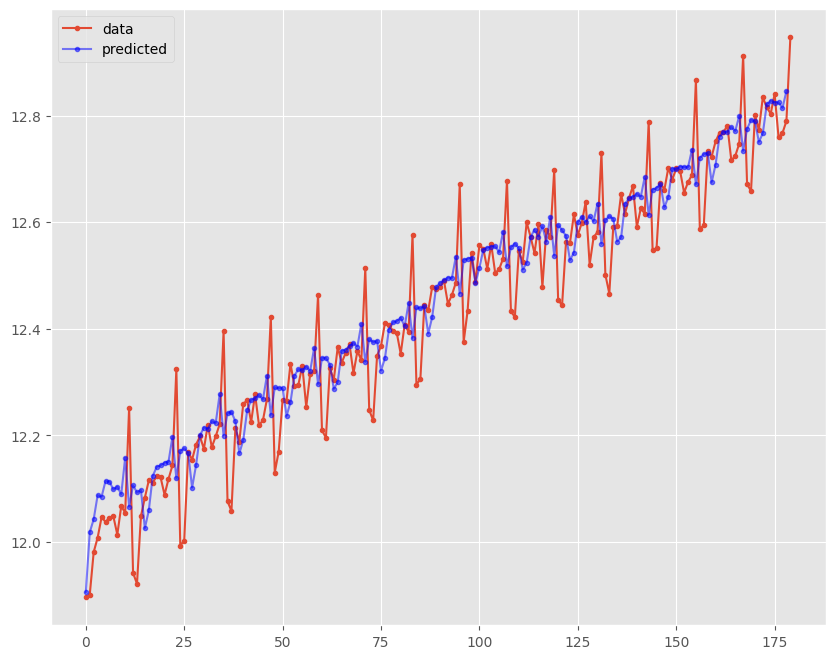

In [41]:
arima = ARIMA(data_train, order=(4, 2, 1))
arima_fitted = arima.fit()

plt.plot(data_train, label="data", marker=".")
plt.plot(arima_fitted.predict(2, train_size), color="blue", label="predicted", marker=".", alpha=0.5)
plt.legend()
plt.show()

Порівняння статичного прогнозу:

In [42]:
preds_df, metrics_df = generate_dfs(dynamic=False)

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
preds_df

,DATA,"TREND(1,)","AR(4, 0, 0)","MA(4, 2, 0)","ARIMA(4, 2, 1)"
180,12.710595,12.835739,12.823124,12.896124,12.845905
181,12.694781,12.840287,12.805821,12.885975,12.804961
182,12.841450,12.844836,12.835681,12.955894,12.839418
183,12.799640,12.849384,12.858667,12.997273,12.863655
184,12.887893,12.853932,12.827630,13.033597,12.891628
185,12.849470,12.858481,12.822202,13.023949,12.862896
186,12.838192,12.863029,12.832304,13.066193,12.855960
187,12.879293,12.867577,12.833911,13.117320,12.877550
188,12.786756,12.872126,12.824716,13.136312,12.889510
189,12.827979,12.876674,12.822834,13.159773,12.894049


In [44]:
metrics_df

,TREND,AR,MA,ARIMA
mse,0.005426,0.004411,0.141535,0.006201
mae,0.059143,0.054554,0.343497,0.063599
mape,0.004621,0.004251,0.026759,0.004968
theil,0.80818,0.870891,1.576777,0.796559


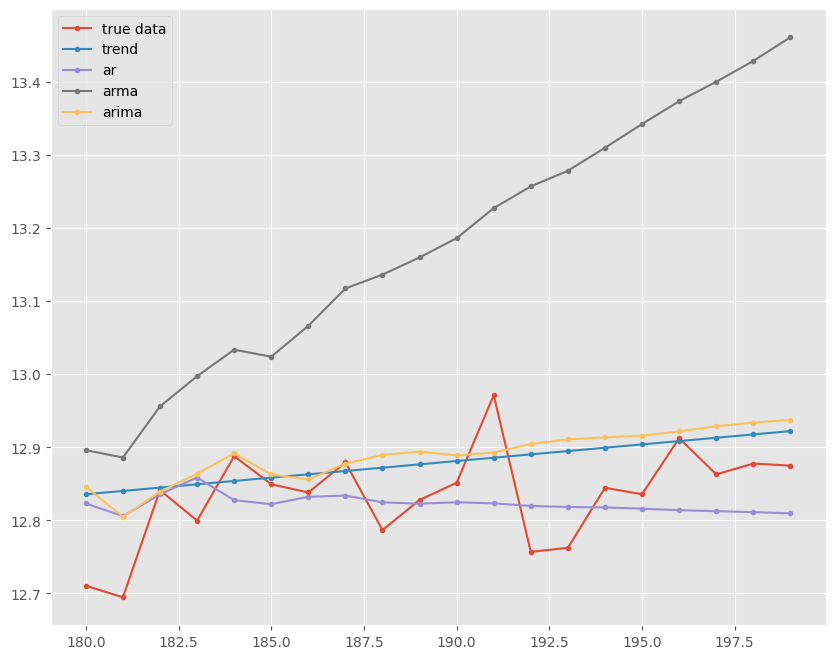

In [45]:
plt.plot(indexes[train_size:], data_test, label="true data", marker=".")

plt.plot(preds_df['TREND(1,)'], label="trend", marker=".")
plt.plot(preds_df['AR(4, 0, 0)'], label="ar", marker=".")
plt.plot(preds_df['MA(4, 2, 0)'], label="arma", marker=".")
plt.plot(preds_df['ARIMA(4, 2, 1)'], label="arima", marker=".")
plt.legend()
# plt.xticks(ticks=range(0, 37, 2), labels=range(750, 787, 2))
plt.show()

Порівняння динамічного прогнозу:

In [46]:
preds_df, metrics_df = generate_dfs(dynamic=True)

c:\Users\igali\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
preds_df

,DATA,"TREND(1,)","AR(4, 0, 0)","MA(4, 2, 0)","ARIMA(4, 2, 1)"
180,12.710595,12.835739,12.823124,12.896124,12.845905
181,12.694781,12.840287,12.805821,12.885975,12.804961
182,12.841450,12.844836,12.835681,12.955894,12.839418
183,12.799640,12.849384,12.858667,12.997273,12.863655
184,12.887893,12.853932,12.827630,13.033597,12.891628
185,12.849470,12.858481,12.822202,13.023949,12.862896
186,12.838192,12.863029,12.832304,13.066193,12.855960
187,12.879293,12.867577,12.833911,13.117320,12.877550
188,12.786756,12.872126,12.824716,13.136312,12.889510
189,12.827979,12.876674,12.822834,13.159773,12.894049


In [48]:
metrics_df

,TREND,AR,MA,ARIMA
mse,0.005426,0.004411,0.141535,0.006201
mae,0.059143,0.054554,0.343497,0.063599
mape,0.004621,0.004251,0.026759,0.004968
theil,0.80818,0.870891,1.576777,0.796559


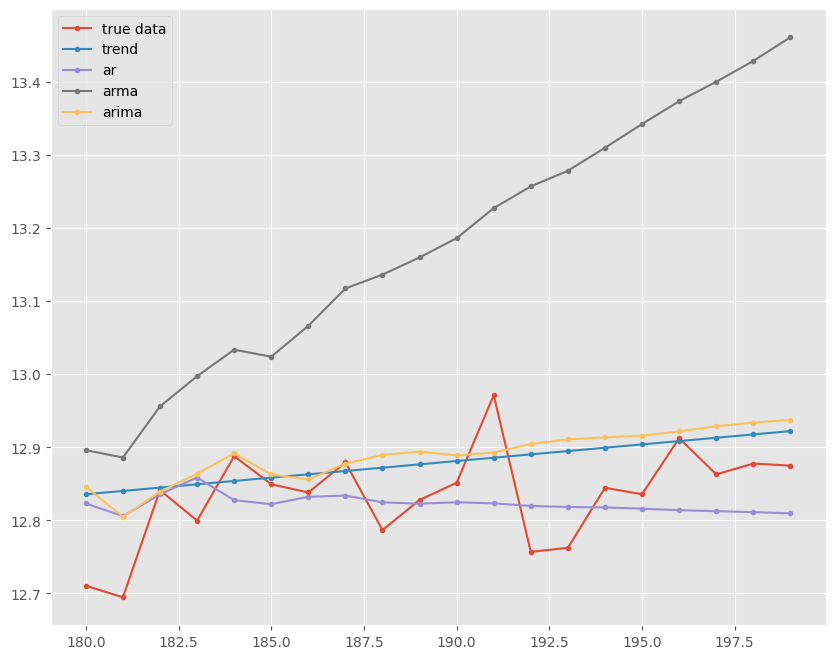

In [49]:
plt.plot(indexes[train_size:], data_test, label="true data", marker=".")

plt.plot(preds_df['TREND(1,)'], label="trend", marker=".")
plt.plot(preds_df['AR(4, 0, 0)'], label="ar", marker=".")
plt.plot(preds_df['MA(4, 2, 0)'], label="arma", marker=".")
plt.plot(preds_df['ARIMA(4, 2, 1)'], label="arima", marker=".")
plt.legend()
# plt.xticks(ticks=range(0, 37, 2), labels=range(750, 787, 2))
plt.show()